In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from summit.strategies.tsemo import TSEMO, TSEMOInternalWrapper
from summit.benchmarks import DTLZ2
from summit.utils.models import GPyModel
from summit.utils.multiobjective import pareto_efficient, hypervolume
from summit.utils.dataset import DataSet

from pymoo.model.problem import Problem
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.optimize import minimize
from pymoo.factory import get_termination

from GPy.kern import Exponential
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import warnings
from fastprogress.fastprogress import master_bar, progress_bar
from IPython.display import clear_output

In [21]:
#Run the DTLZ2 benchmark
batch_size = 1
errors = 0
num_inputs=3
num_objectives=2
lab = DTLZ2(num_inputs=num_inputs, 
            num_objectives=num_objectives)
tsemo_options = dict(pop_size=100,                          #population size for NSGAII
                     iterations=100,                        #iterations for NSGAII
                     n_spectral_points=1500,                #number of spectral points for spectral sampling
                     num_restarts=1,                      #number of restarts for GP optimizer (LBSG)
                     parallel=True)                         #operate GP optimizer in parallel


warnings.filterwarnings("ignore", category=RuntimeWarning)
input_min = DataSet(np.zeros([1, num_inputs]), columns=[f'x_{i}' for i in range(num_inputs)])
input_max = DataSet(np.ones([1, num_inputs]), columns=[f'x_{i}' for i in range(num_inputs)])
tsemo = TSEMO(lab.domain, random_rate=0.00, 
              inputs_min=input_min, inputs_max=input_max)
experiments = tsemo.suggest_experiments(5*num_inputs)
# experiments = pd.read_csv('3x3_lhs_matlab.csv', names=[f'x_{i}' for i in range(num_inputs)])
# experiments = DataSet.from_df(experiments)

for i in range(100):
    print(f"Iteration {i}")
    # Run experiments
    experiments = lab.run_experiments(experiments)

    # Get suggestions
    experiments = tsemo.suggest_experiments(batch_size, experiments,
                                            **tsemo_options)
    
    # Hypervolume
    clear_output(wait=True)
    pareto, _ = pareto_efficient(lab.data[['y_0', 'y_1']].to_numpy(), maximize=False)
    hv = hypervolume(pareto, [11,11])
    
    #Plot pareto front
    fig, ax = plt.subplots()
    ax.set_title(f'Iteration {i}, Hv:{round(hv, 3)}, HvI: {round(tsemo.hv_imp,3)}')
    
    #Experiments before last round
    ax.scatter(lab.data['y_0'].iloc[:-batch_size], 
               lab.data['y_1'].iloc[:-batch_size], 
               alpha=0.2, c='k', label="Past experiments")
    
    #Proposed experiments drawn using NSGA-II
    samples = tsemo.samples[-1]
    cs = ax.scatter(samples['y_0'], samples['y_1'], c=samples['hvi'])
    cb = plt.colorbar(cs,ax=ax)
    cb.set_label('Proposed Experiments (NSGA-II) HvI')
    
    #Point(s) chosen
    if i > 0:
        ax.scatter(last_predictions['y_0'],
                   last_predictions['y_1'],
                   marker="*", s=100, c="Red", label="Last experiment(s) chosen (predicted)")
        ax.scatter(lab.data['y_0'].iloc[-batch_size:], 
                   lab.data['y_1'].iloc[-batch_size:], 
                   marker="*", s=100,c="Green", label="Last experiment(s) chosen (actual)")
    last_predictions = experiments
    ax.scatter(experiments['y_0'], experiments['y_1'], 
               marker="*", s=100, c='blue', label="New experiment(s) chosen (predicted)")
    ax.legend(loc=(1.5,0.5))
    plt.show()
    
    # RMSE
#     y_true = lab.data[['y_0', 'y_1']]
#     x_train = lab.data[[f'x_{i}' for i in range(num_inputs)]]
#     x_train = (x_train-tsemo.inputs_min.to_numpy())/(tsemo.inputs_max.to_numpy()-tsemo.inputs_min.to_numpy())
#     y_pred_scaled = tsemo.models.predict(x_train, use_spectral_sample=True)
#     y_pred = y_pred_scaled*tsemo.output_mean.to_numpy()+tsemo.output_std.to_numpy()
#     rmse = np.sqrt(np.mean((y_pred-y_true)**2, axis=0))
#     print(f"RMSE Train y_0={rmse[0].round(2)}, RMSE Train y_1={rmse[1].round(2)}")
    
# tsemo.save(f'new_tsemo_params_{j}.json')

Iteration 0
> /Users/Kobi/Documents/Research/summit/summit/strategies/tsemo.py(150)suggest_experiments()
    149         import ipdb; ipdb.set_trace()
--> 150         num_restarts=kwargs.get("num_restarts", 100)
    151         print(f"Fitting models (number of optimization restarts={num_restarts})\n")



ipdb>  self.output_mean


NAME  TYPE
y_0   DATA    0.742661
y_1   DATA    0.740187
dtype: float64


ipdb>  outputs


NAME       y_0       y_1
TYPE      DATA      DATA
0     0.998174  0.680157
0     0.590422  1.051050
0     0.342082  0.963208
0     0.886255  0.777841
0     0.788258  0.898470
0     1.144382  0.035207
0     0.836696  0.900626
0     0.702656  1.005280
0     1.156957  0.207295
0     0.296284  1.018877
0     1.297464  0.318320
0     0.027904  1.275158
0     0.876445  0.484237
0     1.062964  0.366579
0     0.132969  1.120504


ipdb>  self.outputs_std


*** AttributeError: 'TSEMO' object has no attribute 'outputs_std'


ipdb>  self.output_std


NAME  TYPE
y_0   DATA    0.389619
y_1   DATA    0.372731
dtype: float64


ipdb>  (0.998174-0.742661)/0.389619


0.6558022067712304


ipdb>  outputs_scaled


NAME       y_0       y_1
TYPE      DATA      DATA
0     0.655802 -0.161056
0    -0.390737  0.834013
0    -1.028130  0.598342
0     0.368550  0.101022
0     0.117031  0.424656
0     1.031061 -1.891389
0     0.241352  0.430441
0    -0.102678  0.711217
0     1.063337 -1.429694
0    -1.145676  0.747696
0     1.423963 -1.131826
0    -1.834501  1.435271
0     0.343372 -0.686688
0     0.822094 -1.002353
0    -1.564841  1.020349


ipdb>  q


BdbQuit: 

In [15]:
experiments

,computation_t,experiment_t,strategy,x_0,x_1,x_2,y_0,y_1
0,31.8275,0.00430202,TSEMO,0.083128,0.034708,0.574533,1.211648,0.15912


In [25]:
initial_experiments = pd.read_csv('3x3_lhs_matlab.csv', names=[f'x_{i}' for i in range(num_inputs)])
initial_experiments = DataSet.from_df(initial_experiments)
initial_experiments

,x_0,x_1,x_2
0,0.567350,0.083249,0.710000
1,0.636960,0.316330,0.053560
2,0.090246,0.832940,0.383260
3,0.686040,0.686730,0.158930
4,0.416350,0.940610,0.235110
5,0.048265,0.402710,0.909890
6,0.221350,0.030186,0.611280
7,0.356330,0.790760,0.427650
8,0.855830,0.923380,0.963350
9,0.925400,0.516170,0.072187


In [12]:
y_pred_y0 = tsemo.models['y_0'].predict(initial_experiments)
y_pred_y1 = tsemo.models['y_1'].predict(initial_experiments)
y_pred = tsemo.models.predict(initial_experiments)
print(y_pred_y0[:,0].all() == y_pred[:,0].all())
print(y_pred_y1[:,0].all() == y_pred[:,1].all())

dtlz2 = DTLZ2(num_inputs=3)
y_true = dtlz2.run_experiments(initial_experiments)
y_true = y_true[['y_0', 'y_1']].to_numpy()

y_pred_unscaled = y_pred*tsemo.output_mean.to_numpy()+tsemo.output_std.to_numpy()
rmse = np.sqrt(np.mean((y_pred_unscaled-y_true)**2, axis=0))
print(rmse)

True
True
[0.47135332 0.446781  ]


True

In [ ]:
optimizer = NSGA2(pop_size=100)
problem = TSEMOInternalWrapper(tsemo.models, tsemo.domain)
termination = get_termination("n_gen", 100)
res = minimize(
    problem, optimizer, termination, seed=1, verbose=False
)
plt.scatter(res.F[:,0], res.F[:,1])

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x123d33400>)

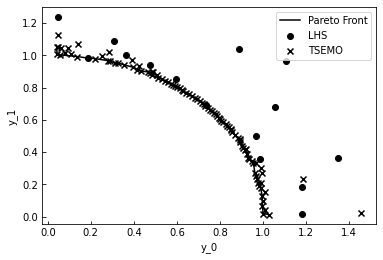

In [15]:
lab.pareto_plot()

In [18]:
hypervolume(lab.pareto_data[['y_0', 'y_1']].to_numpy(), [11,11])

119.65194323239311

In [24]:
experiments

,x_0,x_1,x_2,y_0,y_1,strategy,y_0_variance,y_0_noise,y_0_x_0_lengthscale,y_0_x_1_lengthscale,y_0_x_2_lengthscale,iterations,y_1_variance,y_1_noise,y_1_x_0_lengthscale,y_1_x_1_lengthscale,y_1_x_2_lengthscale
81,0.529031,0.47203,0.445756,0.676216,0.742176,TSEMO,0.858638,0.002479,3.212489,73.537735,3.206437,100,0.7008,0.002479,2.504781,33.315465,4.978001


In [23]:
pareto_data = lab.pareto_data
pareto_data[(pareto_data['x_0']>0.49)&(pareto_data['x_0']<0.51)]

,computation_t,experiment_t,iterations,strategy,x_0,x_1,x_2,y_0,y_0_noise,y_0_variance,y_0_x_0_lengthscale,y_0_x_1_lengthscale,y_0_x_2_lengthscale,y_1,y_1_noise,y_1_variance,y_1_x_0_lengthscale,y_1_x_1_lengthscale,y_1_x_2_lengthscale
50,72.885,0.0238981,NaN,TSEMO,0.504847,0.419792,0.461530,0.707256,NaN,NaN,NaN,NaN,NaN,0.718108,NaN,NaN,NaN,NaN,NaN
97,80.9609,0.0274248,NaN,TSEMO,0.496483,0.458281,0.440273,0.714776,NaN,NaN,NaN,NaN,NaN,0.706922,NaN,NaN,NaN,NaN,NaN


In [22]:
lab.data[lab.data['strategy']=='TSEMO']

,computation_t,experiment_t,iterations,strategy,x_0,x_1,x_2,y_0,y_0_noise,y_0_variance,y_0_x_0_lengthscale,y_0_x_1_lengthscale,y_0_x_2_lengthscale,y_1,y_1_noise,y_1_variance,y_1_x_0_lengthscale,y_1_x_1_lengthscale,y_1_x_2_lengthscale
15,73.97,0.025182,NaN,TSEMO,0.124833,0.950282,0.570621,1.184597,NaN,NaN,NaN,NaN,NaN,0.235308,NaN,NaN,NaN,NaN,NaN
16,69.052,0.0227399,NaN,TSEMO,0.008931,0.975987,0.019932,1.456886,NaN,NaN,NaN,NaN,NaN,0.020441,NaN,NaN,NaN,NaN,NaN
17,69.4382,0.0223081,NaN,TSEMO,0.941704,0.659721,0.342914,0.096032,NaN,NaN,NaN,NaN,NaN,1.045787,NaN,NaN,NaN,NaN,NaN
18,83.5232,0.0492129,NaN,TSEMO,0.169301,0.671625,0.530611,0.994170,NaN,NaN,NaN,NaN,NaN,0.270802,NaN,NaN,NaN,NaN,NaN
19,86.8174,0.0243907,NaN,TSEMO,0.333477,0.485789,0.426138,0.870812,NaN,NaN,NaN,NaN,NaN,0.503025,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,86.3887,0.0239279,NaN,TSEMO,0.271195,0.413233,0.453369,0.919465,NaN,NaN,NaN,NaN,NaN,0.417234,NaN,NaN,NaN,NaN,NaN
110,89.007,0.0242312,NaN,TSEMO,0.688204,0.600876,0.488145,0.475274,NaN,NaN,NaN,NaN,NaN,0.891546,NaN,NaN,NaN,NaN,NaN
111,82.6666,0.0228529,NaN,TSEMO,0.213864,0.405458,0.440612,0.955870,NaN,NaN,NaN,NaN,NaN,0.333763,NaN,NaN,NaN,NaN,NaN
112,84.5713,0.0253732,NaN,TSEMO,0.362041,0.431355,0.438550,0.849757,NaN,NaN,NaN,NaN,NaN,0.543103,NaN,NaN,NaN,NaN,NaN
